In [2]:
import json
from kafka import KafkaConsumer
from kafka import KafkaProducer
from elasticsearch import Elasticsearch
import pandas as pd
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import re
from sklearn.naive_bayes import GaussianNB
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [4]:
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer

In [5]:
stopwords_set = set(stopwords.words('english'))
es = Elasticsearch()
porter = PorterStemmer()

In [94]:
def cleanup_tweet(text):
    tknzr = TweetTokenizer()
    
    text = text.lower()
    
    tokens = tknzr.tokenize(text)
    clean_tokens = []
    
    for token in tokens:
        # Skip hashtags
        if token[0] == "#":
            continue
            
        # Some words end with ":" or "!" are treated as non words. I'd like to include those actually.
        # An example is: "very happy!". Basically, it's a valid ngram, but sign at the end of word
        # results in it being treated as invalid word
        token = re.sub(r'[!:,]$', '', token)
        
        # Doesnt start with letter? Not a word, IMO
        if not re.match("^[a-zA-Z]+", token):
            continue
            
        # Link? Skip it!
        if re.match("^http[s]:\/\/", token):
            continue
            
        # Skip stopwords
        if token in stopwords_set:
            continue
            
        # Stem the word
        token = porter.stem(token)

        clean_tokens.append(token)
        
    return " ".join(clean_tokens)

In [8]:
cleanup_tweet("This is so beautiful day and I am so eager and happy about it")

'beauti day eager happi'

In [9]:
emotions_to_parse = ["happy", "sad"]

data = []

for emotion in emotions_to_parse:
    tweets = es.search(index="fetched_tweets", body={"query": {"match": { "full_text": "#" + emotion }}, "size": 10000})

    for msg in tweets['hits']['hits']:
        full_msg_text = None

        # Skip retweeted tweets
        if "retweeted_status" in msg['_source']:
            continue

        data.append({
            'tweet_id': msg['_id'],
            'full_text': msg['_source']['full_text'],
            'emotion': emotion
        })

In [13]:
data_df = pd.DataFrame(data)
data_df.set_index('tweet_id', inplace=True)
data_df['clean_text'] = data_df['full_text'].apply(cleanup_tweet)
data_df.shape

(4267, 3)

In [11]:
deduplicated_df = data_df.loc[~data_df.index.duplicated(keep=False)]

In [12]:
deduplicated_df.shape

(4095, 3)

In [14]:
deduplicated_df.head(10)

,emotion,full_text,clean_text
tweet_id,,,
1136544883064229888,happy,Happy kid ❤\n#happy https://t.co/6F3SnnYA52,happi kid
1136615042869338120,happy,Happy Thursday. #nycsubway #meandyou #happy h...,happi thursday
1136466744850038784,happy,"@maddow ~Looks comfy. #Happy Happy, Kev's dad!🦑",look comfi happi kev' dad
1136438986677923841,happy,Happy New Year 2018 Quotes: #Happy New Year 20...,happi new year quot new year imag new year wis...
1136599233392332801,happy,"Without you, I’m not happy\nbut I hope you’re ...",without happi hope happi watch far away withou...
1136575521205055490,happy,Happy Wife... Happy Life... AND WHAT A LIFE IT...,happi wife happi life life thank
1136439712498016256,happy,Happy #PrideMonth As long as you are #Happy th...,happi long i'm happi
1136531662911787008,happy,Happy Holidays in Ibiza!\n#HappyTravelling\n#H...,happi holiday ibiza
1136540774370140160,happy,Happy!!! #eid #eidmubarak #idulfitri #lebaran ...,happi


In [16]:
tokens_list = []

for tweet_id, clean_text in deduplicated_df.clean_text.iteritems():
    for token in clean_text.split():
        
        tokens_list.append([
            tweet_id, 
            token, 
            data_df.loc[tweet_id].emotion,
            data_df.loc[tweet_id].clean_text,
            data_df.loc[tweet_id].full_text
        ])

tokens_df = pd.DataFrame(data=tokens_list, columns=['tweet_id', 'token', 'emotion', 'clean_text', 'full_text'])

In [17]:
total_word_counts = tokens_df.groupby('emotion').count()
total_word_counts

,tweet_id,token,clean_text,full_text
emotion,,,,
happy,8584,8584,8584,8584
sad,27756,27756,27756,27756


In [18]:
tokens_df['total_words'] = tokens_df['emotion'].apply(lambda x: total_word_counts.loc[x]['tweet_id'])

In [19]:
word_counts = tokens_df.groupby(['emotion', 'token'])['tweet_id'].count()
word_counts.head()

emotion  token             
happy    a1                    1
         aamazingpapercraft    1
         abil                  2
         abl                   3
         aboard                1
Name: tweet_id, dtype: int64

In [20]:
def get_occurences_of_word_in_emotion(word, emotion):
    try:
        cnt = word_counts.loc[emotion].loc[word]
    except:
        cnt = 0
    return cnt

In [21]:
tokens_df['n'] = tokens_df.apply(lambda x: get_occurences_of_word_in_emotion(x['token'], x['emotion']), 1)

In [22]:
tokens_df[['emotion', 'token', 'n', 'total_words']].head(20)

,emotion,token,n,total_words
0,happy,happi,148,8584
1,happy,kid,4,8584
2,happy,happi,148,8584
3,happy,thursday,26,8584
4,happy,look,33,8584
5,happy,comfi,1,8584
6,happy,happi,148,8584
7,happy,kev',1,8584
8,happy,dad,3,8584
9,happy,happi,148,8584


In [23]:
tokens_df['term_frequency'] = tokens_df['n'] / tokens_df['total_words']

In [24]:
tokens_df[['emotion', 'token', 'n', 'total_words', 'term_frequency']].head(20)

,emotion,token,n,total_words,term_frequency
0,happy,happi,148,8584,0.017241
1,happy,kid,4,8584,0.000466
2,happy,happi,148,8584,0.017241
3,happy,thursday,26,8584,0.003029
4,happy,look,33,8584,0.003844
5,happy,comfi,1,8584,0.000116
6,happy,happi,148,8584,0.017241
7,happy,kev',1,8584,0.000116
8,happy,dad,3,8584,0.000349
9,happy,happi,148,8584,0.017241


In [25]:
tokens_df.drop_duplicates('token', inplace=True)

In [26]:
tokens_df[['emotion', 'token', 'n', 'total_words', 'term_frequency']].head(20)

,emotion,token,n,total_words,term_frequency
0,happy,happi,148,8584,0.017241
1,happy,kid,4,8584,0.000466
3,happy,thursday,26,8584,0.003029
4,happy,look,33,8584,0.003844
5,happy,comfi,1,8584,0.000116
7,happy,kev',1,8584,0.000116
8,happy,dad,3,8584,0.000349
10,happy,new,44,8584,0.005126
11,happy,year,30,8584,0.003495
12,happy,quot,6,8584,0.000699


In [27]:
import math

In [28]:
def get_idf_for_word(word):
    N = 2 # We are working with two emotions, so ...
    
    occurences = tokens_df[tokens_df['token'] == word]['token'].count()
    
    return math.log10(N / occurences)
    

In [29]:
get_idf_for_word('year')

0.3010299956639812

In [30]:
tokens_df['idf'] = tokens_df['token'].apply(lambda x: get_idf_for_word(x))

In [32]:
tokens_df['tf_idf'] = tokens_df['term_frequency'] * tokens_df['idf']

In [33]:
tokens_df[tokens_df['emotion'] == 'happy'][['token', 'term_frequency', 'idf', 'tf_idf']].sort_values(by='tf_idf', ascending=False).head(10)

,token,term_frequency,idf,tf_idf
0,happi,0.017241,0.30103,0.005190
131,make,0.012582,0.30103,0.003787
203,love,0.011650,0.30103,0.003507
82,day,0.011650,0.30103,0.003507
38,life,0.008737,0.30103,0.002630
101,good,0.006757,0.30103,0.002034
161,time,0.006174,0.30103,0.001859
955,like,0.006058,0.30103,0.001824
451,today,0.005708,0.30103,0.001718
66,birthday,0.005359,0.30103,0.001613


In [35]:
tokens_df[tokens_df['emotion'] == 'sad'][['token', 'term_frequency', 'idf', 'tf_idf']].sort_values(by='tf_idf', ascending=False).head(10)

,token,term_frequency,idf,tf_idf
9422,trump,0.006629,0.30103,0.001996
9021,presid,0.004215,0.30103,0.001269
8721,ignor,0.001441,0.30103,0.000434
8753,embarrass,0.001441,0.30103,0.000434
9568,uk,0.001405,0.30103,0.000423
9139,american,0.001333,0.30103,0.000401
10142,fake,0.001261,0.30103,0.000380
8729,america,0.001261,0.30103,0.000380
9441,polit,0.001117,0.30103,0.000336
8702,understand,0.001081,0.30103,0.000325


In [40]:
happy_emotion_token_data = tokens_df[tokens_df['emotion'] == 'happy'][['token', 'term_frequency', 'idf', 'tf_idf']].sort_values(by='tf_idf', ascending=False)
sad_emotion_token_data = tokens_df[tokens_df['emotion'] == 'sad'][['token', 'term_frequency', 'idf', 'tf_idf']].sort_values(by='tf_idf', ascending=False)


In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [49]:
X = deduplicated_df.full_text.values
y = deduplicated_df.emotion.values
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [41]:
def get_feature_tokens(num_features):
    """Returns number of feature words times 2
    
    e.g. if you pass "3" as num_features, it will return top 3 tokens
    from "happy" dataset and top 3 from "sad" dataset, producing total
    of 6 features.
    """
    
    return np.append(happy_emotion_token_data.token.head(num_features).values, sad_emotion_token_data.token.head(num_features).values)

In [42]:
get_feature_tokens(3)

array(['happi', 'make', 'love', 'trump', 'presid', 'ignor'], dtype=object)

In [43]:
def vectorize_tweet_using_feature_array(raw_tweet, features_array):
    clean_tweet = cleanup_tweet(raw_tweet)
    
    vector = {word: 0 for word in features_array}
    
    for token in clean_tweet.split():
        if token not in vector:
            continue
            
        vector[token] += 1
        
    return vector

In [62]:
# Let's see how increasing number of features affects the outcome

scores = []

for num_features in range(10, 100):
    feature_tokens = get_feature_tokens(num_features) # Get features (tokens) to use as vectors
    
    train_vectors = [vectorize_tweet_using_feature_array(tweet, feature_tokens) for tweet in X_train]
    test_vectors = [vectorize_tweet_using_feature_array(tweet, feature_tokens) for tweet in X_test]
    
    train_df = pd.DataFrame(data=train_vectors, columns=feature_tokens)
    test_df = pd.DataFrame(data=test_vectors, columns=feature_tokens)
    
    model = MultinomialNB()
    model.fit(train_df, y_train)
    
    y_train_predicted = model.predict(train_df)
    y_pred = model.predict(test_df)
    
    accuracy_score_train_data = accuracy_score(y_train, y_train_predicted)
    accuracy_score_test_data = accuracy_score(y_test, y_pred)
    
    print(num_features)

    scores.append([num_features, accuracy_score_train_data, accuracy_score_test_data])

10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [63]:
scores_nparray = np.array(scores)

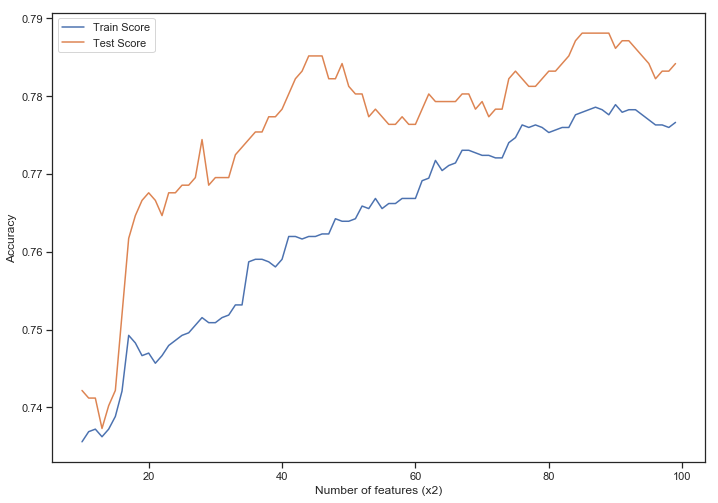

In [64]:
sns.set_style('ticks')
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(11.7, 8.27)
plt.plot(scores_nparray[:, 0], scores_nparray[:, 1], label="Train Score")
plt.plot(scores_nparray[:, 0], scores_nparray[:, 2], label="Test Score")
plt.xlabel('Number of features (x2)')
plt.ylabel('Accuracy');
ax.legend()

In [72]:
np.amax(scores_nparray[:, 2])

0.7880859375

In [73]:
np.where(scores_nparray[:, 2] == max(scores_nparray[:, 2]))

(array([75, 76, 77, 78, 79]),)

In [74]:
scores_nparray[75]

array([85.        ,  0.7779225 ,  0.78808594])

In [58]:
feature_tokens = get_feature_tokens(10)
train_vectors = [vectorize_tweet_using_feature_array(tweet, feature_tokens) for tweet in X_train]
test_vectors = [vectorize_tweet_using_feature_array(tweet, feature_tokens) for tweet in X_test]

train_df = pd.DataFrame(data=train_vectors, columns=feature_tokens)
test_df = pd.DataFrame(data=test_vectors, columns=feature_tokens)

model = MultinomialNB()
model.fit(train_df, y_train)

y_train_predicted = model.predict(train_df)
y_pred = model.predict(test_df)

accuracy_score_train_data = accuracy_score(y_train, y_train_predicted)
accuracy_score_test_data = accuracy_score(y_test, y_pred)

In [59]:
accuracy_score_train_data

0.7355910126994465

In [60]:
accuracy_score_test_data

0.7421875

In [99]:
import pickle

In [104]:
output = open('stemming_scores.pkl', 'wb')

# Pickle dictionary using protocol 0.
pickle.dump(scores_nparray, output)

output.close()

In [107]:
pkl_file = open('stemming_scores.pkl', 'rb')

data1 = pickle.load(pkl_file)